In [1]:
import corner
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from tensorflow_probability.substrates import jax as tfp; tfd = tfp.distributions

from calibration.least_squares import least_squares, ChainStats

In [2]:
# True parameters for two-parametric total least squares
n_vars = 2
true_slope_1 = 0.6
true_slope_2 = -0.8
assert abs(true_slope_1**2 + true_slope_2**2 - 1) < 1e-8
true_intercept = 0.5
true_dispersion = 0.3
observation_uncertainty_scale = 0.2

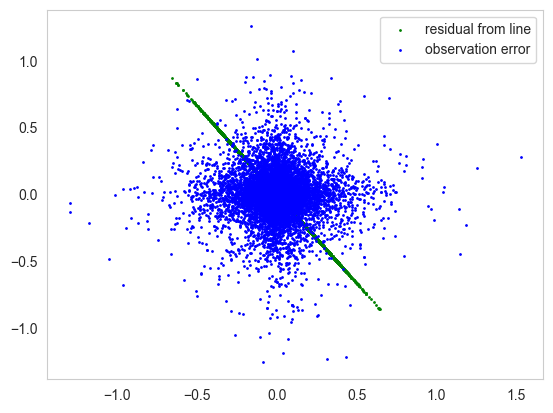

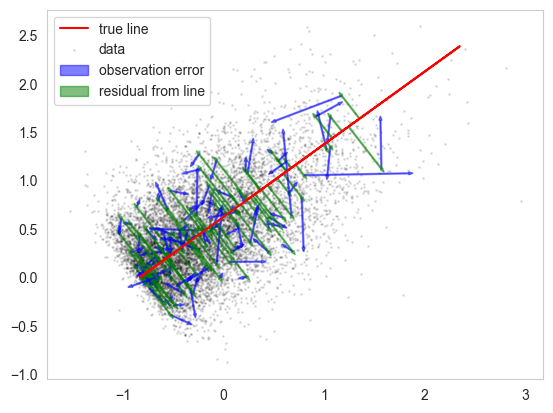

In [3]:
# Generate data for two-parametric total least squares
num_points = 10_000

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
sample_key = jax.random.split(subkey, 1); del subkey
data_residuals = jax.random.normal(sample_key, [num_points]) * true_dispersion; del sample_key

# t can be anything, but we'll use the half normal distribution
key, subkey = jax.random.split(key)
sample_key = jax.random.split(subkey, 1); del subkey
true_t = tfd.HalfNormal(scale=1.0).sample(seed=sample_key, sample_shape=(num_points,)); del sample_key

# jnp.hypot is 1 (see assert above), but we do it just to be explicit
true_x_1 = -true_intercept / true_slope_1 + true_t * jnp.abs(true_slope_2) / jnp.hypot(true_slope_1, true_slope_2)
true_x_2 = (-true_intercept - true_slope_1 * true_x_1) / true_slope_2
assert jnp.allclose(true_slope_1 * true_x_1 + true_slope_2 * true_x_2 + true_intercept, 0.0, atol=1e-6)
assert jnp.allclose((true_x_1 - true_x_1[0])**2 + (true_x_2 - true_x_2[0])**2, (true_t - true_t[0])**2, atol=1e-6)

# x-uncertainties can be anything, but we'll use the exponential distribution.
# We also change the uncertainties scale over the line
key, subkey = jax.random.split(key)
sample_key1, sample_key2 = jax.random.split(subkey, 2); del subkey
data_sigma_sq1 = jnp.clip(true_t, 0.1, 10.0) * observation_uncertainty_scale**2 * jax.random.exponential(sample_key1, (num_points,)); del sample_key1
data_sigma_sq2 = jnp.clip(true_t, 0.1, 10.0) * observation_uncertainty_scale**2 * jax.random.exponential(sample_key2, (num_points,)); del sample_key2
data_sigma2 = jnp.stack([data_sigma_sq1, data_sigma_sq2], axis=-1)

key, subkey = jax.random.split(key)
sample_key1, sample_key2 = jax.random.split(subkey, 2); del subkey
data_dx1 = jax.random.normal(sample_key1, (num_points,)) * jnp.sqrt(data_sigma_sq1); del sample_key1
data_dx2 = jax.random.normal(sample_key2, (num_points,)) * jnp.sqrt(data_sigma_sq2); del sample_key2

true_line = jnp.stack([true_x_1, true_x_2], axis=-1)
residual_from_line = jnp.stack([true_slope_1, true_slope_2], axis=-1) * data_residuals[:, None]
observation_error = jnp.stack([data_dx1, data_dx2], axis=-1)

plt.figure()
plt.scatter(*residual_from_line.T, s=1, color='g', label='residual from line')
plt.scatter(*observation_error.T, s=1, color='b', label='observation error')
plt.grid()
plt.legend()

data_x = (true_line + residual_from_line + observation_error)

plt.figure()
plt.plot(*true_line.T, 'r-', label='true line')
plt.scatter(*data_x.T, color='k', s=1, alpha=0.1, label='data')
for i, x, y, dx, dy, rx, ry in zip(np.arange(100), *data_x.T, *observation_error.T, *residual_from_line.T):
    plt.arrow(x-dx, y-dy, dx, dy, color='b', alpha=0.5, width=0.01, label='observation error' if i == 0 else None)
    plt.arrow(x-dx-rx, y-dy-ry, rx, ry, color='g', alpha=0.5, width=0.01, label='residual from line' if i == 0 else None)
plt.grid()
plt.legend()

In [10]:
%%time
states, log_probs = least_squares(
    type='total',
    x=data_x,
    sigma2=data_sigma2,
    num_samples=10_000,
    nuts_kwargs=dict(step_size=1e-3, parallel_iterations=1),
    with_dispersion=False,
)

CPU times: user 4.69 s, sys: 39 ms, total: 4.72 s
Wall time: 4.72 s


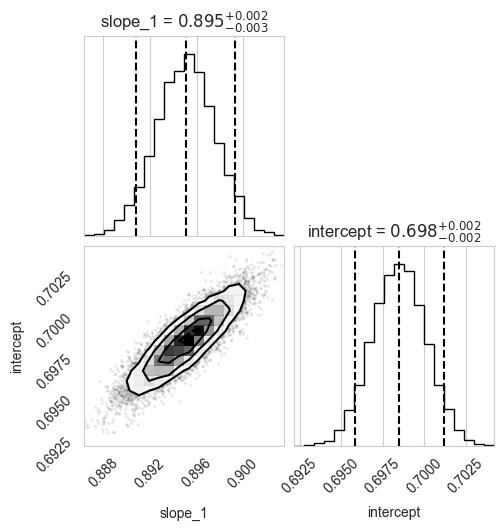

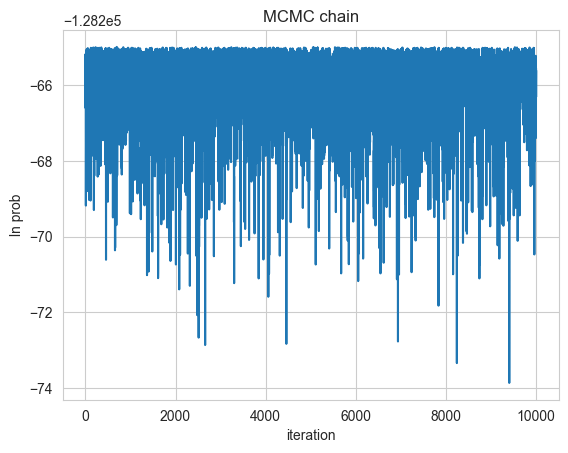

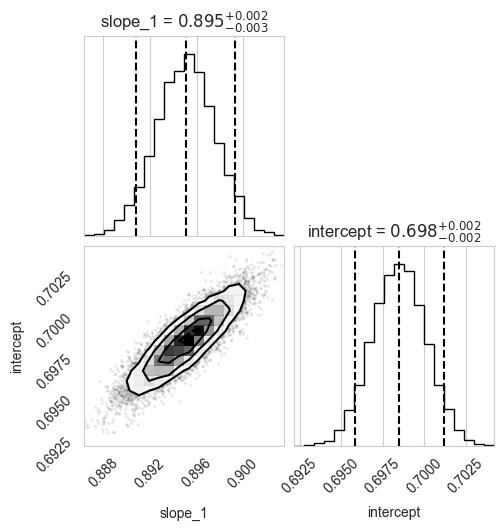

In [15]:
plt.figure()
plt.plot(log_probs)
plt.title('MCMC chain')
plt.xlabel('iteration')
plt.ylabel('ln prob')

stats = ChainStats.from_states(states)
# median_slope_1, median_intercept, median_dispersion = stats.median
# median_slopes = np.array([median_slope_1, -1.0])
# median_slopes_norm = np.linalg.norm(median_slopes)
# median_slopes = median_slopes / median_slopes_norm
# median_intercept /= median_slopes_norm

# plt.figure()
# plt.hist((data_x @ median_slopes + median_intercept) / np.sqrt(data_sigma2 @ median_slopes + median_dispersion**2), bins=100, range=(-3.0, 3.0), alpha=0.5, label='median')
# plt.hist((data_x @ np.array([true_slope_1, true_slope_2]) + true_intercept) / np.sqrt(data_sigma2 @ np.array([true_slope_1, true_slope_2]) + true_dispersion**2), bins=100, range=(-3.0, 3.0), alpha=0.5, label='true')
# plt.legend()
# plt.xlabel('residual')

corner.corner(
    data=np.asarray(states),
    labels=['slope_1', 'intercept'],# 'dispersion'],
    quantiles=[0.05, 0.5, 0.95],
    show_titles=True,
    title_fmt='.3f',
)